# Olist : clusterisation - Model exploration

In [85]:
#librairies import

import pandas as pd
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from datetime import datetime

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

#### Moving on : standardscaling

In [87]:
data = pd.read_csv('data/data_cleaned.csv')
data_RFM = pd.read_csv('data/data_RFM.csv')

In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96096 entries, 0 to 96095
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_unique_id        96096 non-null  object 
 1   first_purchase            96096 non-null  object 
 2   last_purchase             96096 non-null  object 
 3   days_since_last_purchase  96096 non-null  int64  
 4   total_orders              96096 non-null  int64  
 5   total_spent               96096 non-null  float64
 6   average_review_score      279 non-null    float64
 7   all_comments              120 non-null    object 
 8   total_price_items         96096 non-null  float64
 9   total_freight_value       96096 non-null  float64
 10  product_categories        94107 non-null  object 
 11  seller_cities             95420 non-null  object 
 12  order_statuses            96096 non-null  object 
dtypes: float64(4), int64(2), object(7)
memory usage: 9.5+ MB


In [89]:
#need to re-translate last_purchase and first purchase into datetime
columns_to_translate_into_datetime = ['last_purchase', 'first_purchase']
data[columns_to_translate_into_datetime] = data[columns_to_translate_into_datetime].apply(pd.to_datetime)

#same with data_RFM
data_RFM['last_purchase'] = data_RFM['last_purchase'].apply(pd.to_datetime)

In [90]:
#Can't standardscale a datetime column
data_RFM['last_purchase'] = data_RFM['last_purchase'].apply(lambda x: x.timestamp())

In [91]:
data_RFM.head()

,last_purchase,days_since_last_purchase,total_price_items
0,1.534792e+09,864,729.62
1,1.519757e+09,1038,1000.85
2,1.530147e+09,917,664.20
3,1.527853e+09,944,806.61
4,1.518615e+09,1051,855.21


In [92]:
'''#BTW let's check again for nans
null_table(data_RFM)'''

"#BTW let's check again for nans\nnull_table(data_RFM)"

In [93]:
'''#filling the blanks again
for col in data_RFM.columns:
    median = data[col].median()
    data[col] = data[col].fillna(median)

null_table(data_RFM)'''

'#filling the blanks again\nfor col in data_RFM.columns:\n    median = data[col].median()\n    data[col] = data[col].fillna(median)\n\nnull_table(data_RFM)'

In [94]:
'''data_RFM'''

'data_RFM'

In [95]:
#Stand-alone scaling for graphs
scaler = StandardScaler()
data_RFM_scaled = scaler.fit_transform(data_RFM)

C:\Users\kanam\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\kanam\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


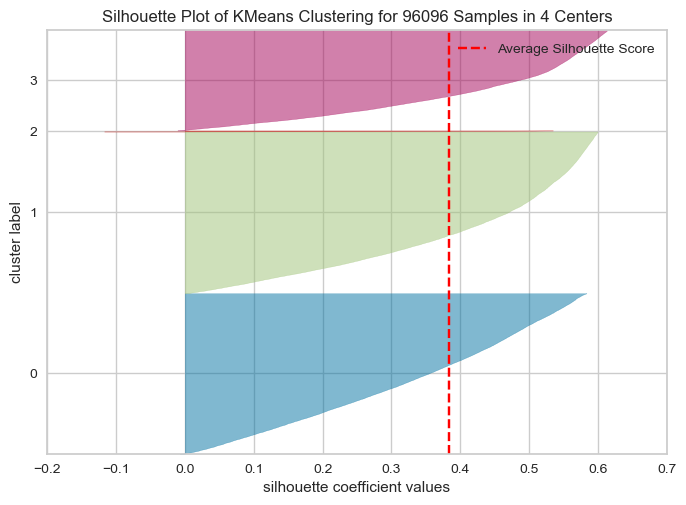

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 96096 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [96]:
#density visualizer Silhouette on 4 clusters
model = KMeans(4, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(data_RFM_scaled)        # Fit the data to the visualizer
visualizer.show() 

silhouette is way longer than Elbow

model = KMeans()
visualizer = KElbowVisualizer(model, metric='silhouette', k=(4,12))

visualizer.fit(data_RFM_scaled)        # Fit the data to the visualizer
visualizer.show()

distortion score + davis bouldin + score silhouette sur le meme graph \
pipeline = standardscaler + reentrainement kmeans final

In [100]:
#Pipeline scaling+training
def train_kmeans(data, scaler, best_k):
    pipeline = Pipeline([
    ('scaler', scaler),
    ('kmeans', KMeans(n_clusters=best_k, random_state=42, n_init=10, init='k-means++'))
])
    return pipeline.fit(data)

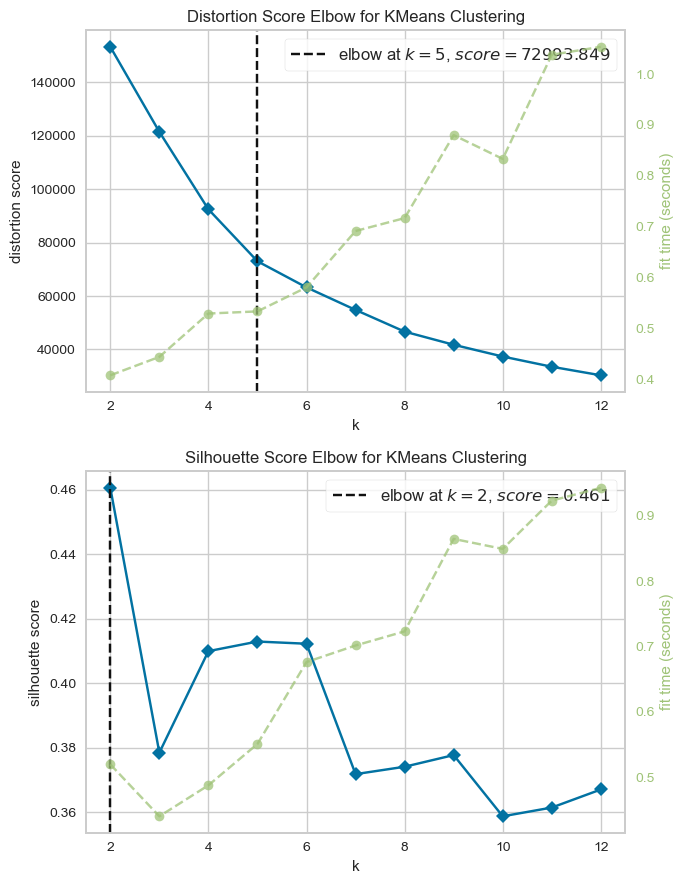

In [101]:
cluster_range = range(2, 13)

# Create subplots
fig, ax = plt.subplots(2, 1, figsize=(7, 9))

# Distortion Score (Elbow Method)
elbow_visualizer = KElbowVisualizer(KMeans(random_state=42, n_init=10), k=cluster_range, ax=ax[0])
elbow_visualizer.fit(data_RFM_scaled)
elbow_visualizer.finalize()

# Silhouette Score
km = KMeans(random_state=42, n_init=10)
visualizer = KElbowVisualizer(km, k=cluster_range, metric='silhouette', ax=ax[1])
visualizer.fit(data_RFM_scaled)
visualizer.finalize()

plt.tight_layout()
plt.show()

Optimal K confirmed between 4 and 2 ? 3 et 5 ? probably 4

Using the total number of clients is not necessarily relevant, due to the only one purchase made bringing very little information

Using only the multiple times buyer :
pros = better information
cons = 97% of data is unusable (only 3000 customers)

Not reasonnably feasable, but worth to mention to olist teams

Adding features : 

- total_orders => indicates if customers returns to olist, and how much so.
- I don't like the all_comments and review_score features, as they are very limited (120 and 279 non-null only)
- total_freight_value => is the client ready to spend with olist despite the distance and increased freigth tarification

Rework the SQL query to include more features ?

récupérer le label attribué avec .labels_
merge avec le dataframe
ensuite groupby cluster pour les analyses
analyse bivariés => corrélation (pearson)

boxplots : feature par cluster ET cluster par features

diagramme RADAR feature par cluster

Enrichir le jeu de données => total_orders / total_freight_value

A tester 
DBSCAN => répartition étrange des clusters => trop peu de données pertinentes
CAH => difficile à faire tourner => n'utiliser que 5% du dataset => Très puissant mais trop gourmand

+ review et correction de code

In [106]:
#pipeline.fit(data_RFM_scaled)
#Using pipeline to train kmeans
km = train_kmeans(data_RFM, StandardScaler(), 4)
km_clusters = km.predict(data_RFM)
km_clusters
# Does the predict method need to be used on scaled data ? Or can it be used on unscaled data
data_RFM['km_cluster'] = km_clusters

In [107]:
data_RFM.head()

,last_purchase,days_since_last_purchase,total_price_items,km_cluster
0,1.534792e+09,864,729.62,2
1,1.519757e+09,1038,1000.85,2
2,1.530147e+09,917,664.20,2
3,1.527853e+09,944,806.61,2
4,1.518615e+09,1051,855.21,2


#### Analyse par cluster

In [109]:
data_cluster = data_RFM.groupby('km_cluster')
cluster_repartition = (data_cluster['km_cluster'].value_counts() / len(data_RFM))*100
cluster_repartition

km_cluster
0    34.365634
1    33.296911
2     9.608100
3    22.729354
Name: count, dtype: float64

On note une grande irrégularité, un des cluster est très peu peuplé

#### Feature by cluster

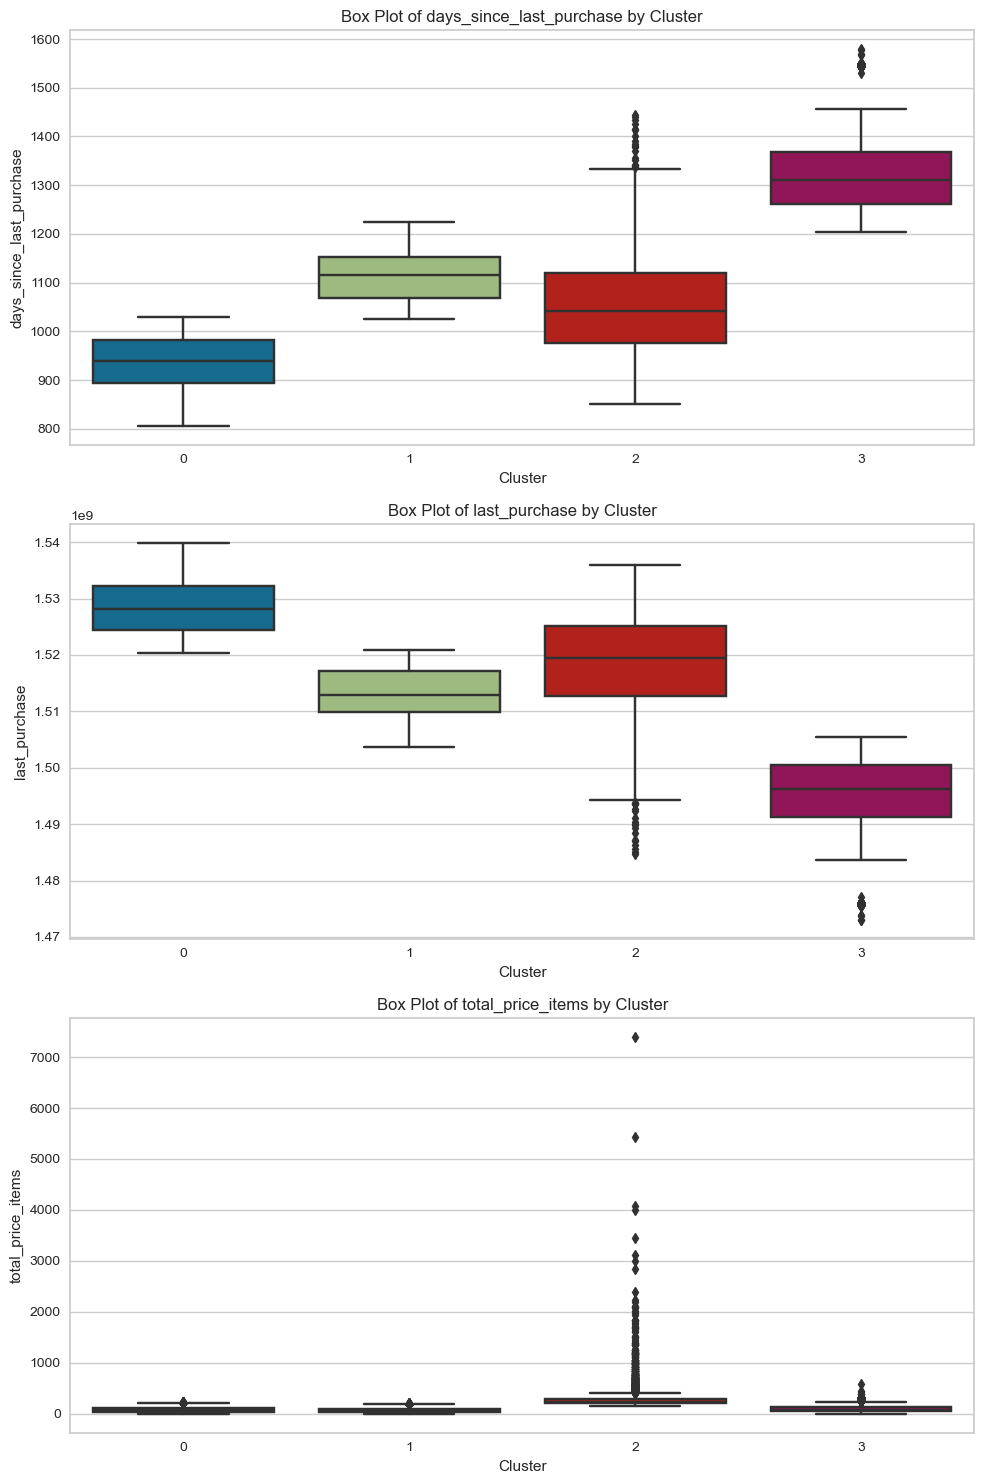

In [112]:
features = data_RFM.columns.difference(['km_cluster'])

# Number of features
num_features = len(features)

# Create subplots
fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(10, 5 * num_features))

# Plot each feature
for i, feature in enumerate(features):
    ax = axes[i] if num_features > 1 else axes
    sns.boxplot(x='km_cluster', y=feature, data=data_RFM, ax=ax)
    ax.set_title(f'Box Plot of {feature} by Cluster')
    ax.set_xlabel('Cluster')
    ax.set_ylabel(feature)

plt.tight_layout()
plt.show()

Looks like the total_price_items needs some more cleaning

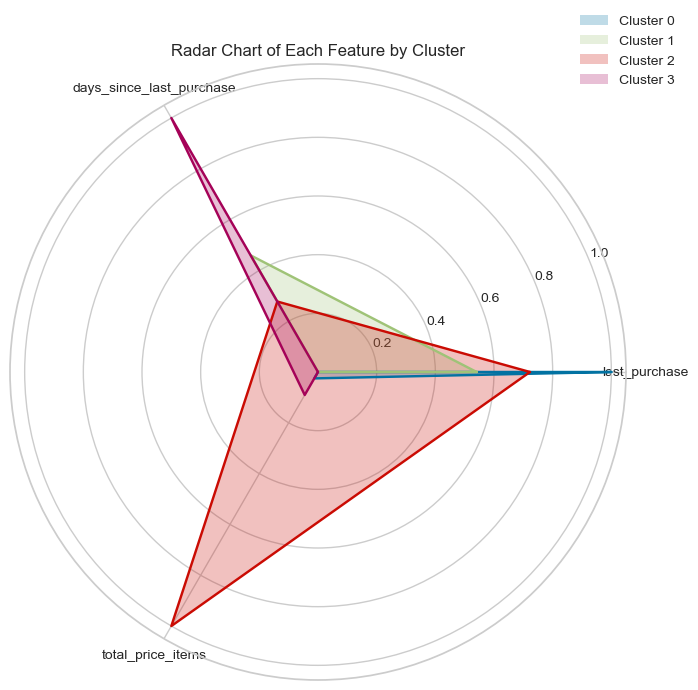

In [114]:
#RADAR
# Calculate the mean of each feature for each cluster
cluster_means = data_RFM.groupby('km_cluster').mean()

# Normalize the feature values
scaler = MinMaxScaler()
cluster_means_normalized = pd.DataFrame(scaler.fit_transform(cluster_means), columns=cluster_means.columns)

# Number of clusters and features
num_clusters = cluster_means_normalized.shape[0]
num_features = cluster_means_normalized.shape[1]

# Create radar chart
angles = np.linspace(0, 2 * np.pi, num_features, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

# Initialize the radar plot
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))

# Plot each cluster
for i in range(num_clusters):
    values = cluster_means_normalized.iloc[i].tolist()
    values += values[:1]  # Complete the loop
    ax.fill(angles, values, alpha=0.25, label=f'Cluster {i}')
    ax.plot(angles, values)

# Add feature labels to the plot
ax.set_xticks(angles[:-1])
ax.set_xticklabels(cluster_means.columns)

# Add a legend
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

# Display the radar chart
plt.title('Radar Chart of Each Feature by Cluster')
plt.show()

#### Cluster by feature

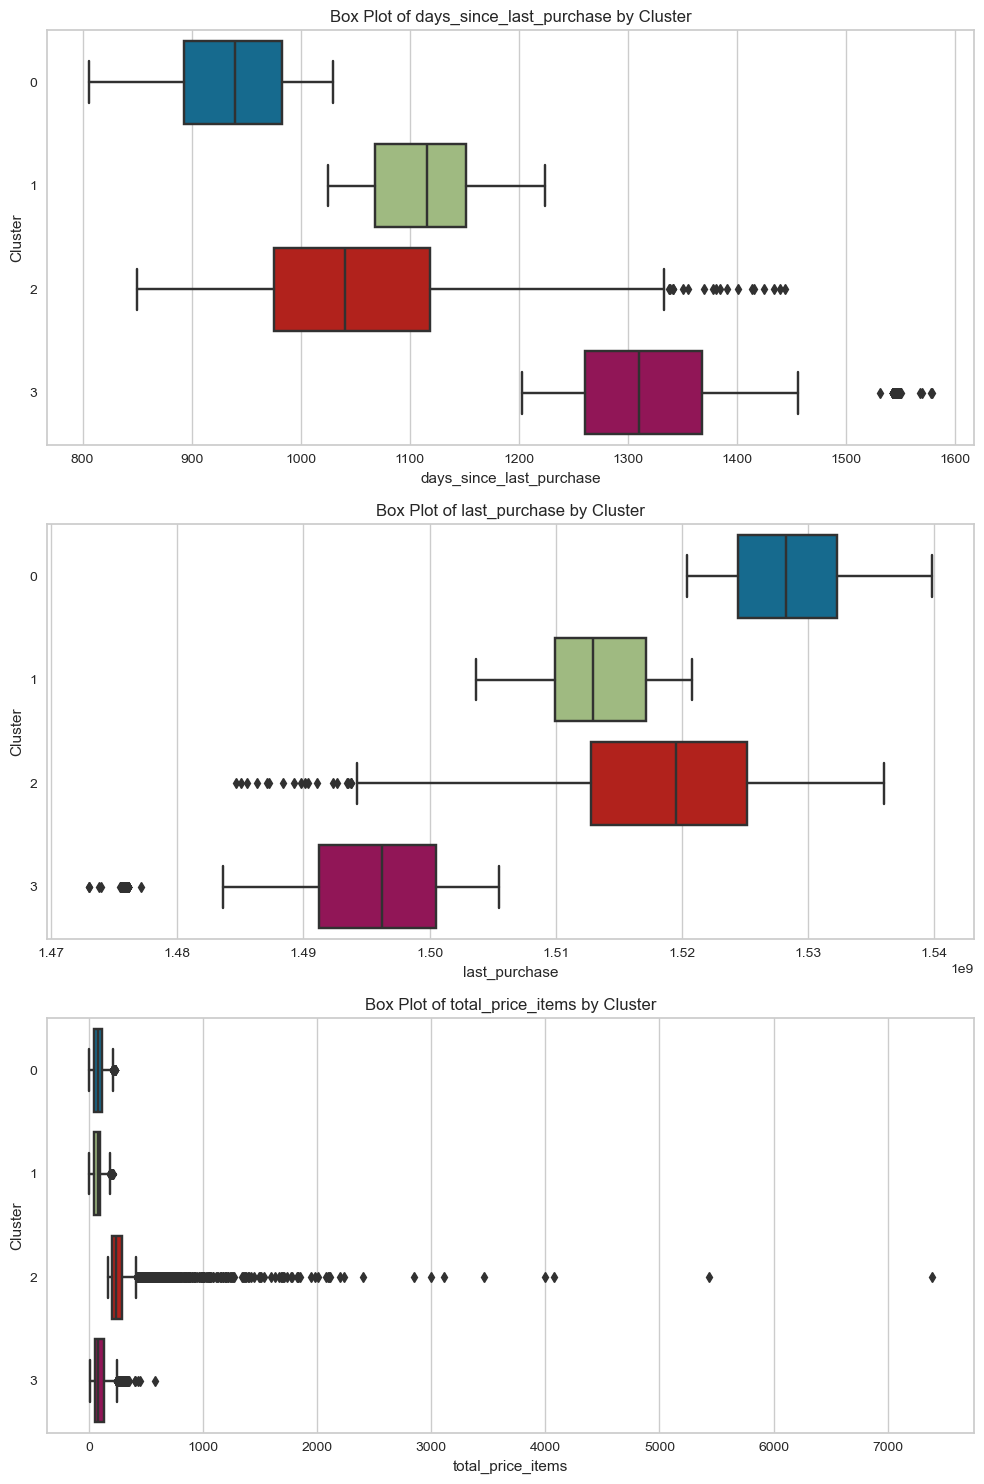

In [116]:
# Get the list of features (excluding the 'cluster' column)
features = data_RFM.columns.difference(['km_cluster'])

# Number of features
num_features = len(features)

# Create subplots
fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(10, 5 * num_features))

# Plot each feature
for i, feature in enumerate(features):
    ax = axes[i] if num_features > 1 else axes
    sns.boxplot(y='km_cluster', x=feature, data=data_RFM, ax=ax, orient='h')
    ax.set_title(f'Box Plot of {feature} by Cluster')
    ax.set_xlabel(feature)
    ax.set_ylabel('Cluster')

plt.tight_layout()
plt.show()

isn't it the same as the previous one ? 

#### Enrich the dataset

In [119]:
#joining two new columns
data_RFM_enriched = data_RFM.join(data['total_freight_value'], how='left')
data_RFM_enriched = data_RFM_enriched.join(data['total_orders'], how='left')

data_RFM_enriched.head()

,last_purchase,days_since_last_purchase,total_price_items,km_cluster,total_freight_value,total_orders
0,1.534792e+09,864,729.62,2,172.42,17
1,1.519757e+09,1038,1000.85,2,171.82,9
2,1.530147e+09,917,664.20,2,94.63,7
3,1.527853e+09,944,806.61,2,316.11,7
4,1.518615e+09,1051,855.21,2,165.91,7


### Fit a new kmeans with new columns

#### New exploration

In [122]:
#drop the cluster to new clusterization
data_RFM_enriched = data_RFM_enriched.drop(columns='km_cluster')
display(data_RFM_enriched.head())

'''#is there NaN ? 
null_table(data_RFM_enriched)'''

,last_purchase,days_since_last_purchase,total_price_items,total_freight_value,total_orders
0,1.534792e+09,864,729.62,172.42,17
1,1.519757e+09,1038,1000.85,171.82,9
2,1.530147e+09,917,664.20,94.63,7
3,1.527853e+09,944,806.61,316.11,7
4,1.518615e+09,1051,855.21,165.91,7


'#is there NaN ? \nnull_table(data_RFM_enriched)'

In [126]:
#Missing values exploration function
def null_table(df):
    missing_values = df.isnull().sum()
    missing_values_percent = (missing_values*100)/len(df)
    table = pd.concat([missing_values, missing_values_percent], axis=1)
    table_renamed = table.rename(
        columns = {0 : "Missing Values", 1  : "Percentage of total"})
    final_table = table_renamed[table_renamed.iloc[:,0] != 0].sort_values(
        by='Missing Values', ascending=False).round(2)
    
    return final_table

In [127]:
#filling NAs
for col in data_RFM_enriched.columns:
    data_RFM_enriched=data_RFM_enriched.fillna(data_RFM_enriched[col].median())
#checking
null_table(data_RFM_enriched)

,Missing Values,Percentage of total


In [128]:
#StandardScale for graphs
scaler = StandardScaler()
data_RFM_enriched_scaled = scaler.fit_transform(data_RFM_enriched)

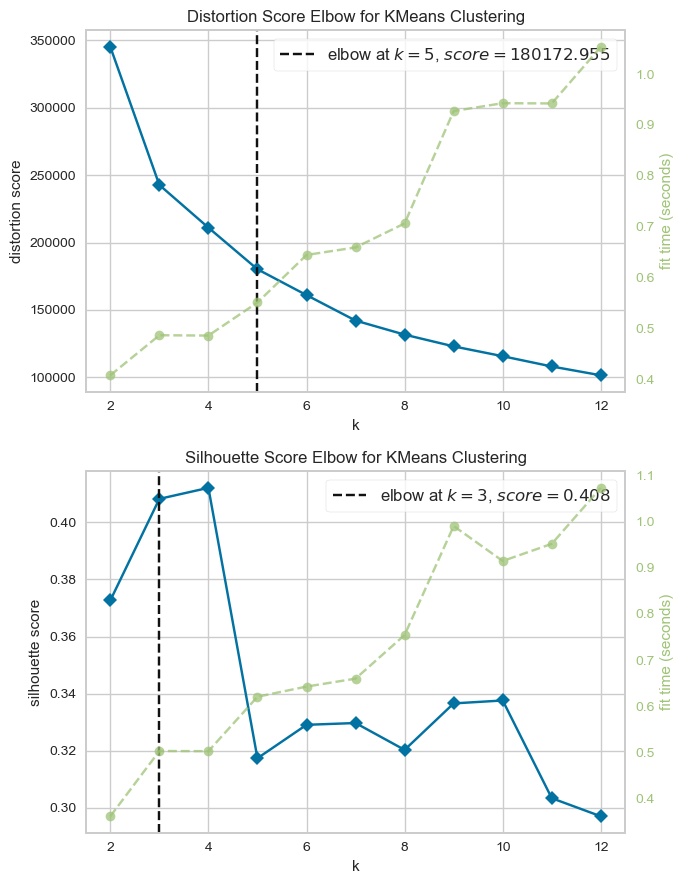

In [129]:
cluster_range = range(2, 13)

# Create subplots
fig, ax = plt.subplots(2, 1, figsize=(7, 9))

# Distortion Score (Elbow Method)
elbow_visualizer = KElbowVisualizer(KMeans(random_state=42, n_init=10), k=cluster_range, ax=ax[0])
elbow_visualizer.fit(data_RFM_enriched_scaled)
elbow_visualizer.finalize()

# Silhouette Score
#km = KMeans(random_state=42, n_init=10)
visualizer = KElbowVisualizer(KMeans(random_state=42, n_init=10), k=cluster_range, metric='silhouette', ax=ax[1])
visualizer.fit(data_RFM_enriched_scaled)
visualizer.finalize()

plt.tight_layout()
plt.show()

best k is 4 ?

In [131]:
km_enriched = train_kmeans(data_RFM_enriched, StandardScaler(), 4)

data_RFM_enriched['km_enriched_cluster'] = km_enriched.predict(data_RFM_enriched)
data_RFM_enriched

,last_purchase,days_since_last_purchase,total_price_items,total_freight_value,total_orders,km_enriched_cluster
0,1.534792e+09,864,729.62,172.42,17,2
1,1.519757e+09,1038,1000.85,171.82,9,2
2,1.530147e+09,917,664.20,94.63,7,2
3,1.527853e+09,944,806.61,316.11,7,2
4,1.518615e+09,1051,855.21,165.91,7,2
...,...,...,...,...,...,...
96091,1.528282e+09,939,223.00,19.44,1,3
96092,1.513553e+09,1110,59.00,17.66,1,3
96093,1.501889e+09,1245,143.80,18.90,1,1
96094,1.534106e+09,872,30.00,8.37,1,3


In [132]:
data_cluster = data_RFM_enriched.groupby('km_enriched_cluster')
cluster_repartition = (data_cluster['km_enriched_cluster'].value_counts() / len(data_RFM))*100
cluster_repartition

km_enriched_cluster
0     2.912712
1    41.308691
2     0.206044
3    55.572552
Name: count, dtype: float64

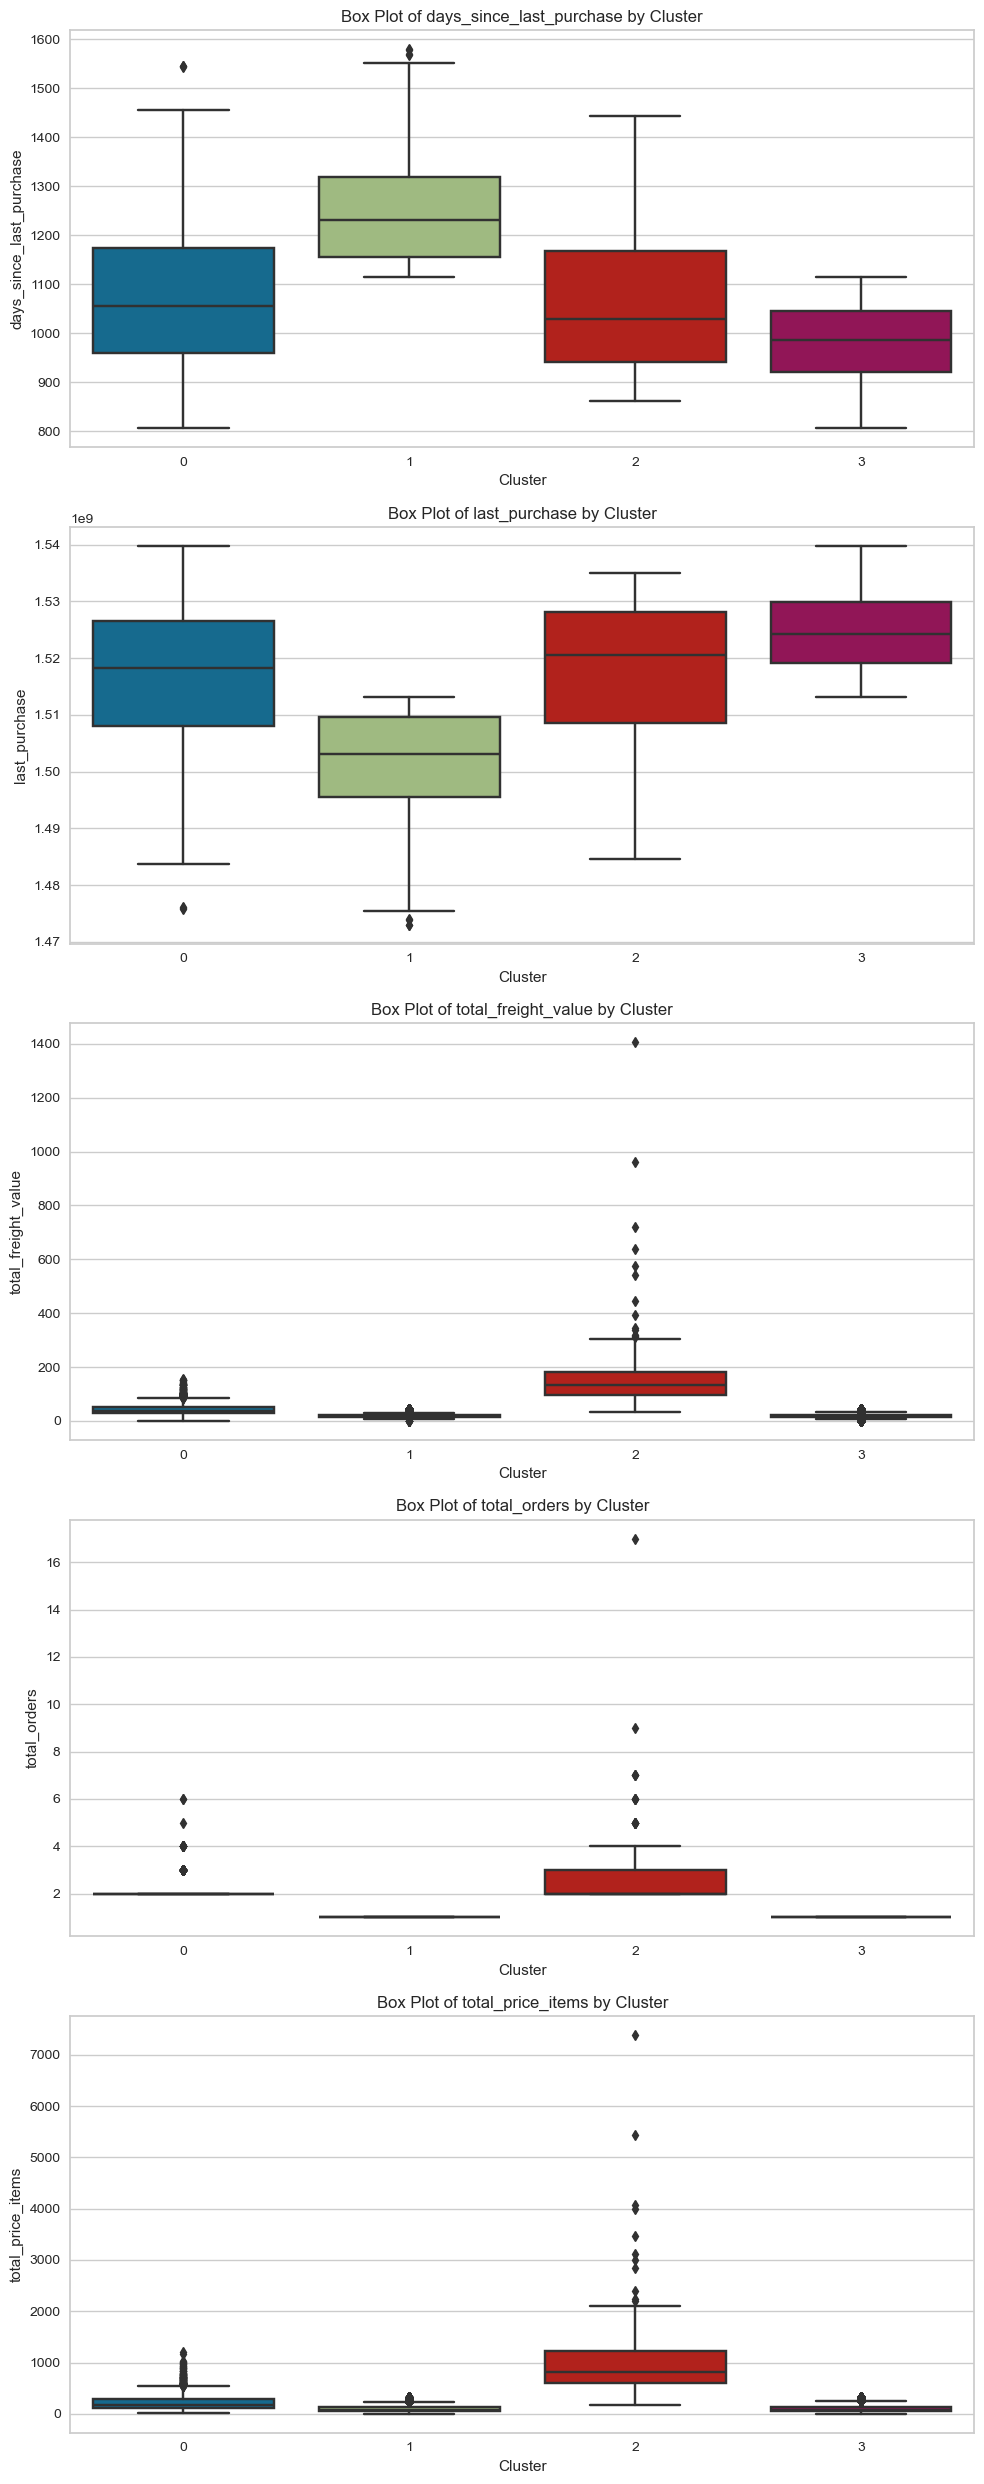

In [133]:
features = data_RFM_enriched.columns.difference(['km_enriched_cluster'])

# Number of features
num_features = len(features)

# Create subplots
fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(10, 5 * num_features))

# Plot each feature
for i, feature in enumerate(features):
    ax = axes[i] if num_features > 1 else axes
    sns.boxplot(x='km_enriched_cluster', y=feature, data=data_RFM_enriched, ax=ax)
    ax.set_title(f'Box Plot of {feature} by Cluster')
    ax.set_xlabel('Cluster')
    ax.set_ylabel(feature)

plt.tight_layout()
plt.show()

It seems that two clusters have very little population

Also, could it be interesting to map the correlation between the two clustering and see if its well correlated or not ?

### DBSCAN approach

In [137]:
clustering = DBSCAN().fit(data_RFM_enriched_scaled)

clusterized = clustering.labels_
data_RFM_enriched['DBSCAN_cluster'] = clustering.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(clusterized)) - (1 if -1 in clusterized else 0)
n_noise_ = list(clusterized).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 17
Estimated number of noise points: 757


37 clusters is far from the first estimation obtained with silhouette score and Elbow method

In [139]:
data_cluster = data_RFM_enriched.groupby('DBSCAN_cluster')
DB_cluster_repartition = (data_cluster['DBSCAN_cluster'].value_counts() / len(data_RFM_enriched))*100
DB_cluster_repartition

DBSCAN_cluster
-1      0.787754
 0      0.006244
 1      2.248793
 2      0.007284
 3      0.005203
 4      0.005203
 5      0.006244
 6      0.009366
 7      0.006244
 8      0.005203
 9      0.010406
 10     0.005203
 11     0.010406
 12     0.005203
 13     0.005203
 14    96.543040
 15     0.322594
 16     0.010406
Name: count, dtype: float64

Only 6 clusters have 1% or more of the data, which is more coherent with the previously obtained estimations

The main problem is that DBSCAN is a density algorithm. Our data only contains 3000 clients with more than 1 purchase, but the clustering is made on all the dataset

### HAC approach

Maybe include customer_unique_id ? Or scale the whole data and stop using a scaled version and unscaled version

In [144]:
#made with AgglomerativeClustering AND sampling first 

sampled_data_RFM_enriched = data_RFM_enriched.sample(frac=0.05, random_state=42)
sampled_data_RFM_enriched = sampled_data_RFM_enriched.drop(columns=['DBSCAN_cluster'])
sampled_data_RFM_enriched_scaled = scaler.fit_transform(sampled_data_RFM_enriched)

HAC_clustering = AgglomerativeClustering().fit(sampled_data_RFM_enriched_scaled)

HAC_clustering.labels_
sampled_data_RFM_enriched['HAC_cluster'] = HAC_clustering.labels_

data_cluster = sampled_data_RFM_enriched.groupby('HAC_cluster')
DB_cluster_repartition = (data_cluster['HAC_cluster'].value_counts() / len(sampled_data_RFM_enriched))*100
DB_cluster_repartition

#running time : 

HAC_cluster
0    45.078044
1    54.921956
Name: count, dtype: float64

### Algorithm choice

Kmeans : 
 - Can be checked with silhouette and Elbow
 - Quick enough
 - Easily adjustable


DBSCAN : 
 - Harder to check
 - Fairly quick
 - harder to adjust

HAC : 
 - Infernally long
 - Difficult to adjust


We can see that the kmeans algorithm is better, faster, and more coherent regarding the data
We will therefore move on with this algorithm, with a clustering of 4

#### Cluster explanation : domain-wise

How to explain each cluster domain-wise


Relying on the boxplot made by cluster :
First clustering
 - Cluster 0 = last purchase
 - Cluster 1 = day since last purchase
 - Cluster 2 = total price items - elite clients
 - Cluster 3 = 3%


### Export final dataset and model

In [150]:
data_RFM_enriched.to_csv('data/data_with_clustering.csv', index = False)

# Save the model
kmeans_final = train_kmeans(data_RFM_enriched, StandardScaler(), 4)
joblib_file = "kmeans_model.pkl"
joblib.dump(kmeans_final, joblib_file)

['kmeans_model.pkl']

In [151]:
data_RFM_enriched.head()

,last_purchase,days_since_last_purchase,total_price_items,total_freight_value,total_orders,km_enriched_cluster,DBSCAN_cluster
0,1.534792e+09,864,729.62,172.42,17,2,-1
1,1.519757e+09,1038,1000.85,171.82,9,2,-1
2,1.530147e+09,917,664.20,94.63,7,2,-1
3,1.527853e+09,944,806.61,316.11,7,2,-1
4,1.518615e+09,1051,855.21,165.91,7,2,-1
